In [1]:
import os, sys

codepath = '/user_data/mmhender/image_stats_gabor/code/'
sys.path.insert(0,codepath)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.stats
import cmocean

from plotting import plot_utils, summary_plots, load_fits
from utils import roi_utils, default_paths, prf_utils
from feature_extraction import gabor_feature_extractor
import copy

#### Load fit results

In [2]:
subjects = np.arange(1,9)
n_subjects = len(subjects)

fitting_type1 = 'gabor_solo_ridge_12ori_8sf'
out = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type1, n_from_end=0, \
                                  verbose=False) for ss in subjects]

n_vox_each_subj = [out[si]['best_params'][0].shape[0] for si in range(n_subjects)]
subject_inds = np.concatenate([si*np.ones((n_vox_each_subj[si],),dtype=int) \
                               for si in range(n_subjects)], axis=0)

# load the semantic voxel groups
# these are already thresholded based on permutation test, so no need to do any other thresholding
from analyze_fits import sem_voxel_groups
sem_groups, sem_group_names = sem_voxel_groups.get_sem_voxel_groups()
n_sem_groups = len(sem_group_names)

#### Get info about the Gabor feature space

In [3]:
n_sf=8; n_ori=12;
_gabor_ext_complex = gabor_feature_extractor.gabor_extractor_multi_scale(n_ori=n_ori, n_sf=n_sf)

screen_eccen_deg=8.4
sf_cyc_per_stim = _gabor_ext_complex.feature_table['SF: cycles per stim']
sf_cyc_per_deg = sf_cyc_per_stim/screen_eccen_deg
sf_unique, sf_inds = np.unique(sf_cyc_per_deg, return_inverse=True)

ori_deg = _gabor_ext_complex.feature_table['Orientation: degrees']
ori_unique, orient_inds = np.unique(ori_deg, return_inverse=True)


#### Organize the feature sensitivity matrices
feature sensitivity = corr coef between model resp and feature channel activation

In [4]:
feature_corr1 = np.concatenate([out[si]['corr_each_feature'] for si in range(n_subjects)], axis=0)
n_voxels = feature_corr1.shape[0]
allcorr_reshaped1 = np.reshape(feature_corr1, [n_voxels, n_ori, n_sf], order='F')
mean_orient_corr1 = np.mean(allcorr_reshaped1, axis=2)
mean_sf_corr1 = np.mean(allcorr_reshaped1, axis=1)

# find maxes across orient/SF.
preferred_ori_corr1 = np.argmax(mean_orient_corr1, axis=1).astype(np.float32)
is_constant1 = np.all(np.tile(mean_orient_corr1[:,0:1], [1,n_ori])==mean_orient_corr1, axis=1)
assert(not(np.any(is_constant1)))

preferred_sf_corr1 = np.argmax(mean_sf_corr1, axis=1).astype(np.float32)
is_constant1 = np.all(np.tile(mean_sf_corr1[:,0:1], [1,n_sf])==mean_sf_corr1, axis=1)
assert(not(np.any(is_constant1)))



In [5]:
n_vox = preferred_ori_corr1.shape[0]
feature_prefs_2dhist_orig = np.zeros((n_vox, n_ori, n_sf))
for vv in range(n_vox):
    oo = int(preferred_ori_corr1[vv])
    ff = int(preferred_sf_corr1[vv])
    feature_prefs_2dhist_orig[vv,oo,ff] = 1
   

In [6]:
avg_resp_profiles_orig = np.zeros((n_subjects, n_sem_groups, n_ori, n_sf))

for ri in range(n_sem_groups): 
    
    sem_group_inds = np.concatenate(sem_groups, axis=0)[:,ri]
    
    print(np.sum(sem_group_inds), sem_group_names[ri])
    
    for si in range(n_subjects):
        
        inds_use = sem_group_inds & (subject_inds==si)
        
        avg_resp_profiles_orig[si,ri,:,:] = np.mean(allcorr_reshaped1[inds_use,:,:], axis=0)

4000 face
4000 building
4000 animate
4000 inanimate
4000 small
4000 large
4000 indoor
4000 outdoor


In [7]:
4000/500

8.0

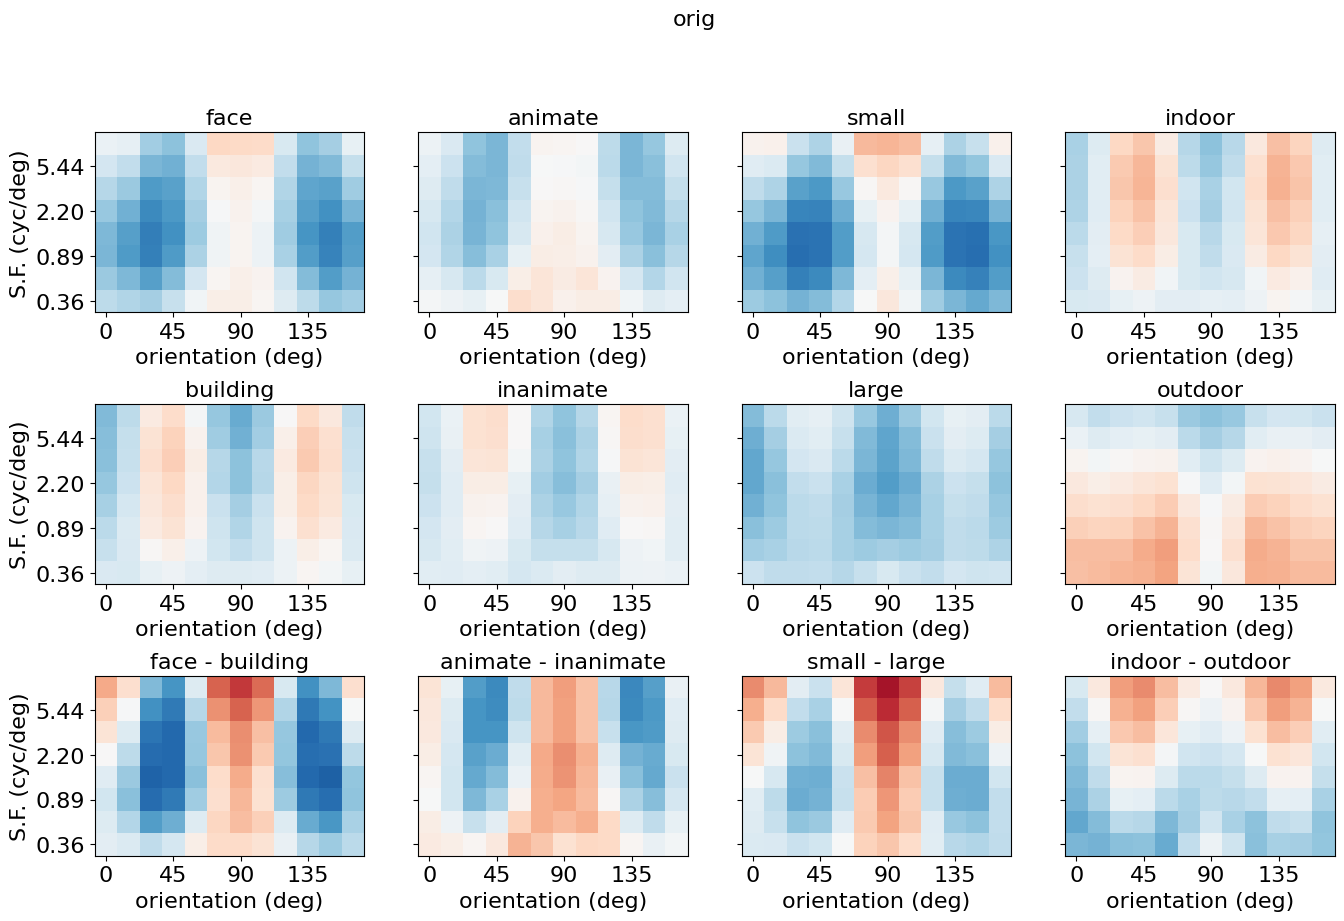

In [7]:
plot_utils.set_all_font_sizes(16)
plt.rcParams['pdf.fonttype']=42

plot_inds = np.array([0,4,8,1,5,9,2,6,10,3,7,11])+1

for rname, respvals in zip(['orig'], [avg_resp_profiles_orig]):

    plt.figure(figsize=(16,10))
    
    pi=0

    clims = [-0.6, 0.6]

    pairs = [[0,1],[2,3],[4,5],[6,7]]

    for pair_ind, pair in enumerate(pairs):

        for xx in [0,1,2]:

            pi+=1
            plt.subplot(3,4,plot_inds[pi-1])

            # print(pair[xx])
            
            if xx<2:
                vals = np.mean(respvals[:,pair[xx],:,:], axis=0)
                name = sem_group_names[pair[xx]]
            else:
                vals = np.mean(respvals[:,pair[0],:,:] - respvals[:,pair[1],:,:], axis=0)
                name = '%s - %s'%(sem_group_names[pair[0]], sem_group_names[pair[1]])

            plt.pcolormesh(vals.T,  vmin=clims[0], vmax=clims[1], cmap=cm.RdBu)

            plt.xticks(np.arange(0,12,3)+0.5, np.arange(0,180,45))
            sf_ticks = sf_unique[[0,2,4,6]].round(2)
            if pair_ind==0:
                plt.yticks(np.array([0,2,4,6])+0.5, ['%.2f'%sf for sf in sf_ticks])
                plt.ylabel('S.F. (cyc/deg)')
            else:
                plt.yticks(np.array([0,2,4,6])+0.5,[])
            plt.axis('square')
            plt.xlim([0,12])
            plt.ylim([0,8])
            # plt.axis('off')
            # plt.colorbar()

            plt.xlabel('orientation (deg)')
            # else:
            #     plt.yticks(np.array([0,2,4,6])+0.5, [])

            plt.title(name)

    plt.suptitle(rname)
# plt.suptitle('sensitivity profile, averaged within ROIs\n%s'%summary_plots.get_substr(out_orig))

fn2save = os.path.join(default_paths.fig_path, 'Feature_selectivity_sem_voxel_groups.pdf')
plt.savefig(fn2save)

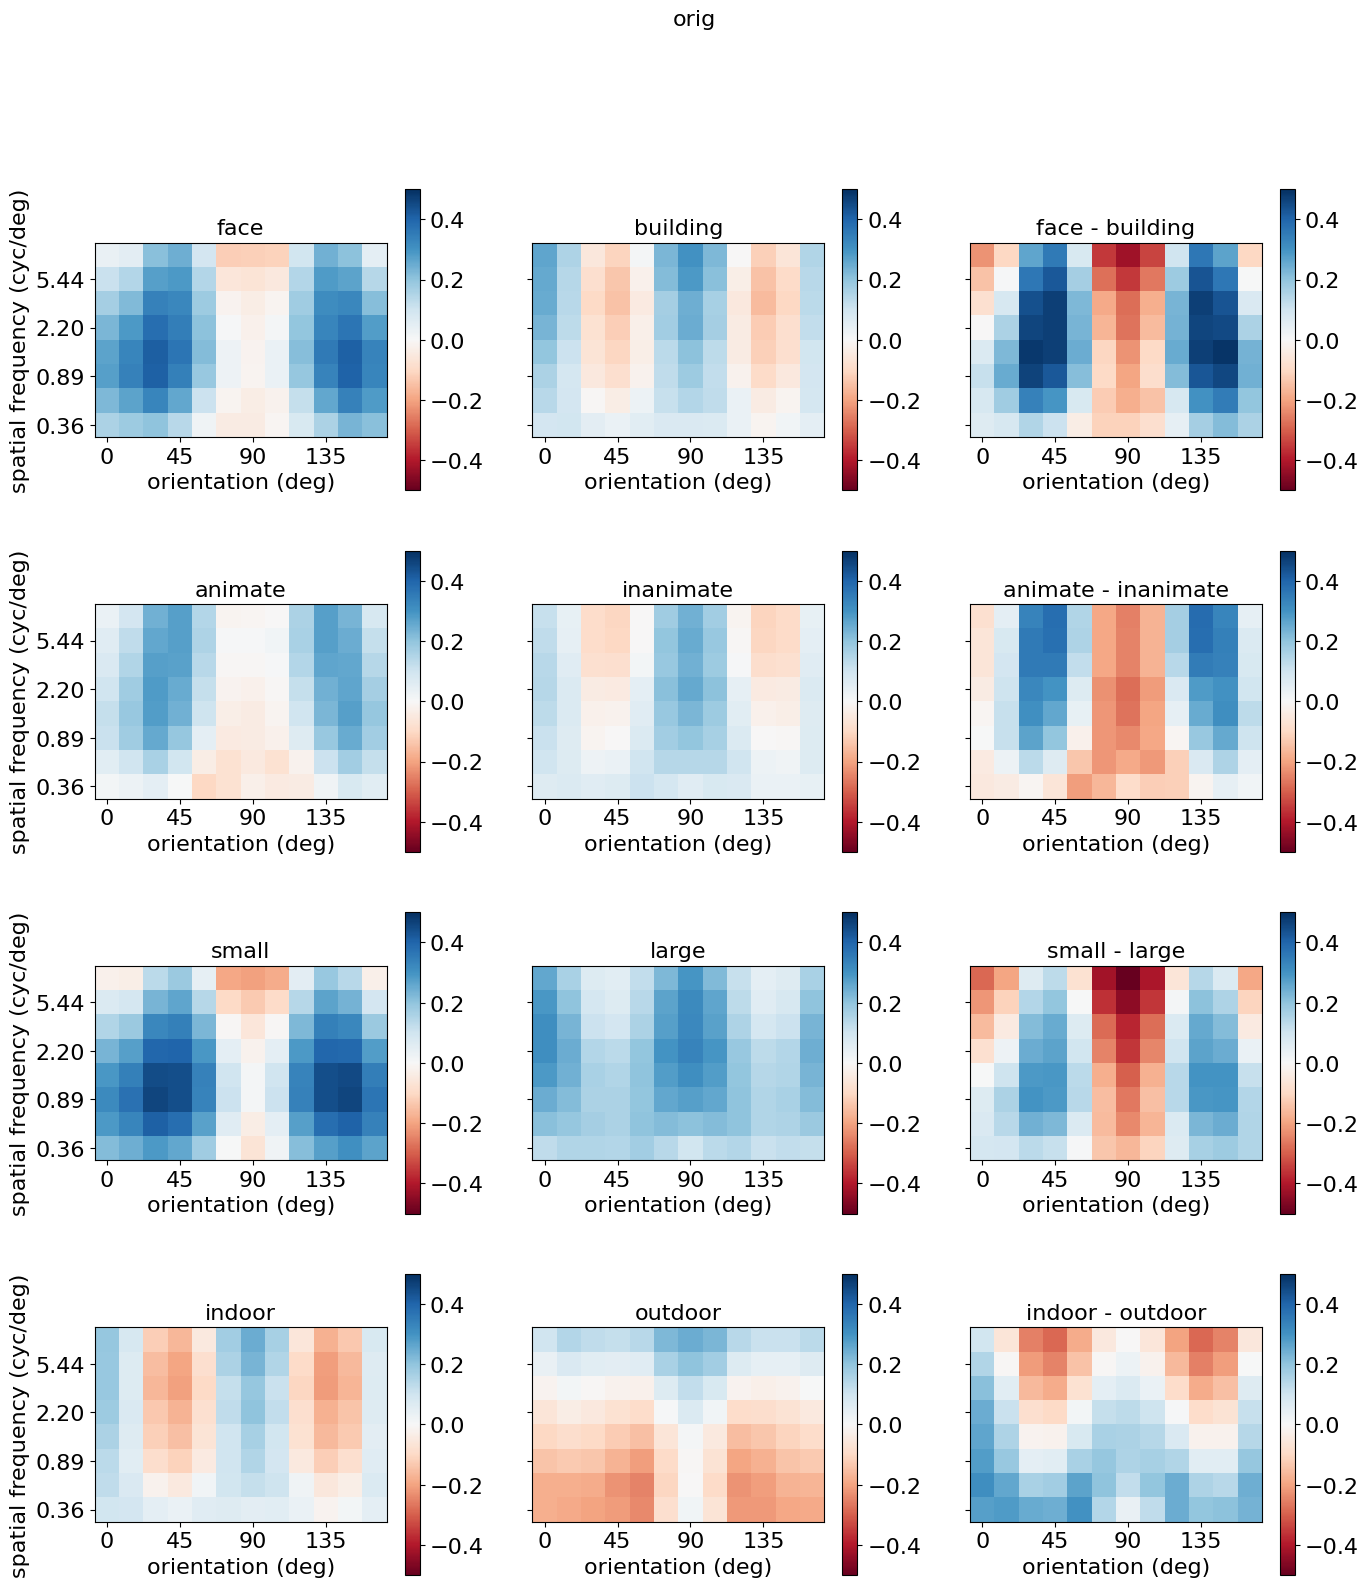

In [ ]:
plot_utils.set_all_font_sizes(16)
plt.rcParams['pdf.fonttype']=42

for rname, respvals in zip(['orig'], [avg_resp_profiles_orig]):

    plt.figure(figsize=(16,18))
    
    pi=0

    clims = [-0.5, 0.5]

    pairs = [[0,1],[2,3],[4,5],[6,7]]

    for pair in pairs:

        for xx in [0,1,2]:

            pi+=1
            plt.subplot(4,3,pi)

            # print(pair[xx])
            
            if xx<2:
                vals = np.mean(respvals[:,pair[xx],:,:], axis=0)
                name = sem_group_names[pair[xx]]
            else:
                vals = np.mean(respvals[:,pair[0],:,:] - respvals[:,pair[1],:,:], axis=0)
                name = '%s - %s'%(sem_group_names[pair[0]], sem_group_names[pair[1]])

            plt.pcolormesh(vals.T,  vmin=clims[0], vmax=clims[1], cmap=cm.RdBu)

            plt.xticks(np.arange(0,12,3)+0.5, np.arange(0,180,45))
            sf_ticks = sf_unique[[0,2,4,6]].round(2)
            if xx==0:
                plt.yticks(np.array([0,2,4,6])+0.5, ['%.2f'%sf for sf in sf_ticks])
                plt.ylabel('spatial frequency (cyc/deg)')
            else:
                plt.yticks(np.array([0,2,4,6])+0.5,[])
            plt.axis('square')
            plt.xlim([0,12])
            plt.ylim([0,8])
            # plt.axis('off')
            plt.colorbar()

            plt.xlabel('orientation (deg)')
            # else:
            #     plt.yticks(np.array([0,2,4,6])+0.5, [])

            plt.title(name)

    plt.suptitle(rname)
# plt.suptitle('sensitivity profile, averaged within ROIs\n%s'%summary_plots.get_substr(out_orig))

# fn2save = os.path.join(default_paths.fig_path, 'Orient_sensitivity_allareas.pdf')
# plt.savefig(fn2save)

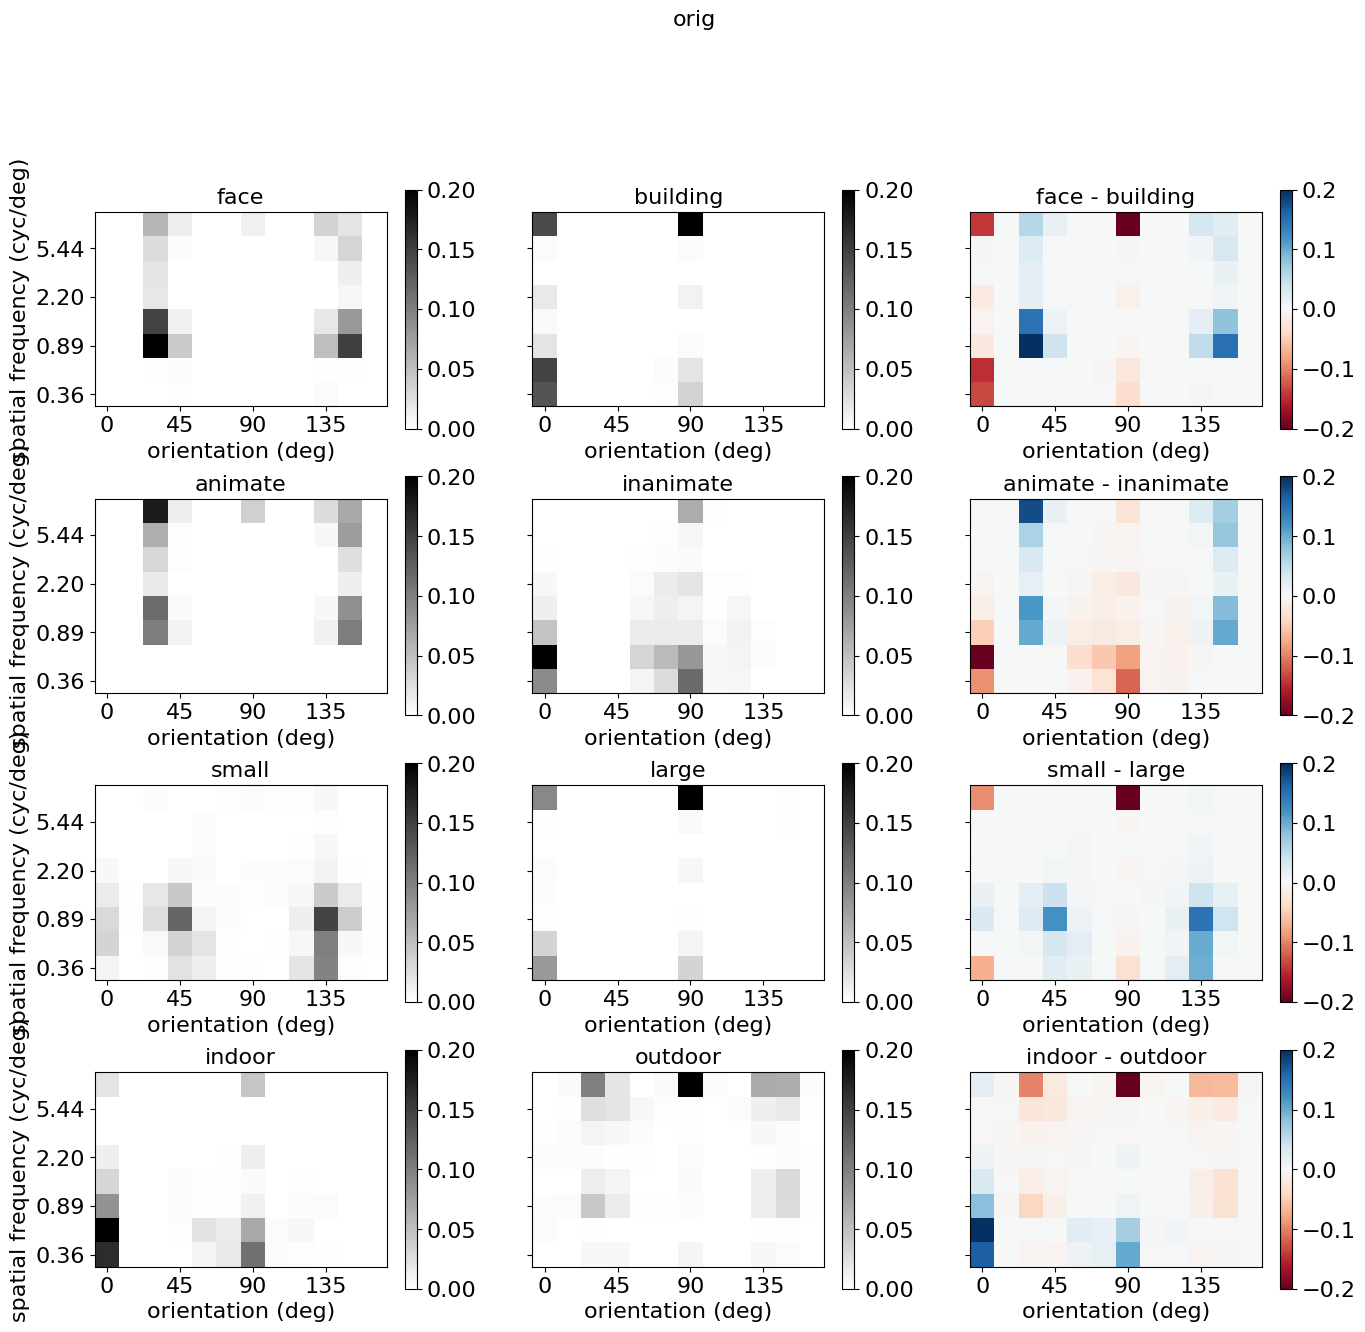

In [ ]:
plot_utils.set_all_font_sizes(16)
plt.rcParams['pdf.fonttype']=42

for hname, histvals in zip(['orig'],[feature_prefs_2dhist_orig]):

    plt.figure(figsize=(16,18))

    pi=0

    clims = [0, 0.20]

    pairs = [[0,1],[2,3],[4,5],[6,7]]

    for pair in pairs:

        rr = pair[0]
        
        sem_group_inds = np.concatenate(sem_groups, axis=0)[:,rr]
        
        vals1 = np.mean(histvals[sem_group_inds,:,:], axis=0)

        rr = pair[1]
        
        sem_group_inds = np.concatenate(sem_groups, axis=0)[:,rr]
        
        vals2 = np.mean(histvals[sem_group_inds,:,:], axis=0)

        for xx in [0,1,2]:

            pi+=1
            plt.subplot(5,3,pi)

            if xx==0:
                vals = vals1;
                name = sem_group_names[pair[0]]
                plt.pcolormesh(vals.T,  vmin=clims[0], vmax=clims[1], cmap=cm.gray_r)

            elif xx==1:
                vals = vals2;
                name = sem_group_names[pair[1]]
                plt.pcolormesh(vals.T,  vmin=clims[0], vmax=clims[1], cmap=cm.gray_r)

            else:
                vals = vals1 - vals2;
                name = '%s - %s'%(sem_group_names[pair[0]],sem_group_names[pair[1]])
                plt.pcolormesh(vals.T,  vmin=-0.2, vmax=0.2, cmap=cm.RdBu)

            plt.xticks(np.arange(0,12,3)+0.5, np.arange(0,180,45))
            sf_ticks = sf_unique[[0,2,4,6]].round(2)
            if xx==0:
                plt.yticks(np.array([0,2,4,6])+0.5, ['%.2f'%sf for sf in sf_ticks])
                plt.ylabel('spatial frequency (cyc/deg)')
            else:
                plt.yticks(np.array([0,2,4,6])+0.5,[])
            plt.axis('square')
            plt.xlim([0,12])
            plt.ylim([0,8])

            plt.colorbar()
            plt.xlabel('orientation (deg)')
            plt.title(name)

    plt.suptitle(hname)
    